In [1]:
import requests
import json
import pandas as pd
import time
import re
import urllib
import matplotlib
import numpy as np
pd.set_option('display.max_colwidth', None)

In [2]:
import boto3
from io import StringIO

In [3]:
s3 = boto3.client('s3')

In [4]:
address = "terra1w579ysjvpx7xxhckxewk8sykxz70gm48wpcuruenl29rhe6p6raslhj0m6"

In [5]:
def get_txs_time_period(_from, _to):
    _df = None
    timestamp = urllib.parse.quote(_from.strftime("%Y-%m-%d+%H:%M:%S"),safe='+')
    while True:
        url = f"""
        https://api.seer.coinhall.org/api/coinhall/swaps/{address}?offset={timestamp}.010646870&limit=15
        """
        print(url)
        # Send a GET request to the API
        response = requests.get(url)
    
        time.sleep(1)
        print(f"Number of txs received: {len(response.json()['txs'])}")
        
        new_df = pd.DataFrame(response.json()['txs'])
        if _df is None:
            _df = new_df
        else:
            _df = pd.concat([_df, new_df])
        _df.timestamp = pd.to_datetime(_df.timestamp)
        min_ts = _df.timestamp.min()
        timestamp = urllib.parse.quote(min_ts.strftime("%Y-%m-%d+%H:%M:%S"),safe='+')

        if(min_ts.to_pydatetime().replace(tzinfo=None).strftime("%Y-%m-%d") < _to.strftime("%Y-%m-%d")):
            break
    return _df

In [6]:
from datetime import datetime, timedelta

current_date = datetime.now()
threshold_day = current_date - timedelta(days=40)

In [7]:
try:
    df = pd.read_csv("./data/astro/swaps.csv")
    df.timestamp = pd.to_datetime(df.timestamp, format='mixed')
except Exception as e:
    print(f"No file yet {e}")
    df = None

In [8]:
if df is None:
    print("No data yet. Downloading it all...")
    df = get_txs_time_period(current_date, threshold_day)
else:
    if df.timestamp.max().to_pydatetime().replace(tzinfo=None) < current_date:
        print(f"Filling the upper gap from {current_date.strftime('%Y-%m-%d')} to {df.timestamp.max().to_pydatetime().replace(tzinfo=None).strftime('%Y-%m-%d')}")
        tt_df = get_txs_time_period(current_date, df.timestamp.max().to_pydatetime().replace(tzinfo=None))
        df = pd.concat([df, tt_df])
    if df.timestamp.min().to_pydatetime().replace(tzinfo=None) > threshold_day:
        print(f"Filling the lower gap from {threshold_day.strftime('%Y-%m-%d')} to {df.timestamp.min().to_pydatetime().replace(tzinfo=None).strftime('%Y-%m-%d')}")
        tt_df = get_txs_time_period(df.timestamp.min().to_pydatetime().replace(tzinfo=None), threshold_day)
        df = pd.concat([df, tt_df])
df = df.drop_duplicates(ignore_index=True)

Filling the upper gap from 2023-07-21 to 2023-07-20

        https://api.seer.coinhall.org/api/coinhall/swaps/terra1w579ysjvpx7xxhckxewk8sykxz70gm48wpcuruenl29rhe6p6raslhj0m6?offset=2023-07-21+14%3A57%3A40.010646870&limit=15
        
Number of txs received: 15

        https://api.seer.coinhall.org/api/coinhall/swaps/terra1w579ysjvpx7xxhckxewk8sykxz70gm48wpcuruenl29rhe6p6raslhj0m6?offset=2023-07-21+14%3A40%3A27.010646870&limit=15
        
Number of txs received: 15

        https://api.seer.coinhall.org/api/coinhall/swaps/terra1w579ysjvpx7xxhckxewk8sykxz70gm48wpcuruenl29rhe6p6raslhj0m6?offset=2023-07-21+12%3A26%3A47.010646870&limit=15
        
Number of txs received: 15

        https://api.seer.coinhall.org/api/coinhall/swaps/terra1w579ysjvpx7xxhckxewk8sykxz70gm48wpcuruenl29rhe6p6raslhj0m6?offset=2023-07-21+08%3A41%3A19.010646870&limit=15
        
Number of txs received: 15

        https://api.seer.coinhall.org/api/coinhall/swaps/terra1w579ysjvpx7xxhckxewk8sykxz70gm48wpcuruenl29rhe6p

In [9]:
assets = {
    'ibc/B3504E092456BA618CC28AC671A71FB08C6CA0FD0BE7C8A5B5A3E2DD933CC9E4':'axlUSDC',
    'terra1nsuqsk6kh58ulczatwev87ttq2z6r3pusulg9r24mfj2fvtzd4uq3exn26':'ASTRO'
}

In [10]:
df = df.drop_duplicates(ignore_index=True)
df.returnAsset = df.returnAsset.replace(assets)
df.offerAsset = df.offerAsset.replace(assets)

In [11]:
df['date'] = df.timestamp.apply(lambda x: x.strftime("%Y-%m-%d"))

In [12]:
df.to_csv(f'data/astro/swaps.csv', index=False)

In [13]:
_sell = df[df.offerAsset=='ASTRO']
_buy = df[df.returnAsset=='ASTRO']
_sell['astro_amount'] =  - _sell.offerAmount
_buy['astro_amount'] =  _buy.returnAmount
df = pd.concat([_sell, _buy])

/tmp/ipykernel_874/2204474832.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _sell['astro_amount'] =  - _sell.offerAmount
/tmp/ipykernel_874/2204474832.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _buy['astro_amount'] =  _buy.returnAmount


In [14]:
from datetime import datetime, timedelta

today = datetime.today()
one_month_earlier = today - timedelta(days=30)
one_month_earlier_date = one_month_earlier.strftime("%Y-%m-%d")
one_week_earlier = today - timedelta(days=7)
one_week_earlier_date = one_week_earlier.strftime("%Y-%m-%d")
today_date = today.strftime("%Y-%m-%d")

print(one_month_earlier_date)
print(one_week_earlier_date)
print(today_date)

2023-06-21
2023-07-14
2023-07-21


In [15]:
def get_df_before_date(df, date, sell=True):  
    if(sell):
        _tt =  df[df.date >= date]\
            [['traderAddress','returnAmount','astro_amount']]\
            .groupby('traderAddress')\
            .sum()
        _tt = _tt[_tt.astro_amount < 0]
    else:
        _tt =  df[df.date >= date]\
            [['traderAddress','offerAmount','astro_amount']]\
            .groupby('traderAddress')\
            .sum()
        _tt = _tt[_tt.astro_amount > 0]
    return _tt.sort_values(by='astro_amount', ascending=sell).reset_index().head(50)

In [16]:
tt_sell_month = get_df_before_date(df, one_month_earlier_date)
tt_sell_week = get_df_before_date(df, one_week_earlier_date)
tt_sell_today = get_df_before_date(df, today_date)

tt_buy_month = get_df_before_date(df, one_month_earlier_date, sell=False)
tt_buy_week = get_df_before_date(df, one_week_earlier_date, sell=False)
tt_buy_today = get_df_before_date(df, today_date, sell=False)

In [17]:
import requests
import json

def get_balances(address):
    url = "https://starscream-terra-mainnet.chainscope.dev/"
    headers = {
        "Content-Type": "application/json"
    }
    
    body = {
        "query": """
        query Query($address: String!, $tokenContracts: [String!]!) {
            tokenBalances(address: $address, tokenContracts: $tokenContracts)
        }
        """,
        "variables": {
            "address": f"{address}",
            "tokenContracts": [
                "terra1x62mjnme4y0rdnag3r8rfgjuutsqlkkyuh4ndgex0wl3wue25uksau39q8",
                "terra1xp9hrhthzddnl7j5du83gqqr4wmdjm5t0guzg9jp6jwrtpukwfjsjgy4f3",
                "terra19p20mfnvwh9yvyr7aus3a6z6g6uk28fv4jhx9kmnc2m7krg27q2qkfenjw",
                "terra1nsuqsk6kh58ulczatwev87ttq2z6r3pusulg9r24mfj2fvtzd4uq3exn26",
                "terra1ecgazyd0waaj3g7l9cmy5gulhxkps2gmxu9ghducvuypjq68mq2s5lvsct",
                "terra1lxx40s29qvkrcj8fsa3yzyehy7w50umdvvnls2r830rys6lu2zns63eelv",
                "terra17aj4ty4sz4yhgm08na8drc0v03v2jwr3waxcqrwhajj729zhl7zqnpc0ml"
            ]
        },
        "operationName": "Query"
    }
    
    response = requests.post(url, headers=headers, data=json.dumps(body))
    
    if response.status_code == 200:
        result = response.json()
        return result
    else:
        print("Request failed with status code:", response.status_code)

In [18]:
tokens = [
"xASTRO",
"SAYVE",
"ORNE",
"ASTRO",
"ampLUNA",
"ROAR",
"boneLuna"
]

In [19]:
addresses = set(tt_sell_month.traderAddress.tolist())\
    .union(set(tt_sell_week.traderAddress.tolist()))\
    .union(set(tt_sell_today.traderAddress.tolist()))\
    .union(set(tt_buy_month.traderAddress.tolist()))\
    .union(set(tt_buy_week.traderAddress.tolist()))\
    .union(set(tt_buy_today.traderAddress.tolist()))

In [20]:
balances = []
for address in addresses:
    balance_dict = {k: int(v)/1000000 for k, v in zip(tokens, get_balances(address)['data']['tokenBalances'])}
    balance_dict['traderAddress']= address
    balances.append(balance_dict)

In [21]:
def add_balances(df, balances, sell=True):
    _tt = df
    if(not sell):
        _tt['dollar_amount'] = _tt.offerAmount
    if(sell):
        _tt['dollar_amount'] = _tt.returnAmount
    _tt = pd.DataFrame(balances).merge(df, on='traderAddress')
    _tt['total_astro_holdings'] = _tt['ASTRO'] + _tt['xASTRO']
    _tt.total_return_dollar_amount = _tt.dollar_amount.apply(int)
    _tt["total_return_dollar_amount_label"] = _tt.total_return_dollar_amount.apply(lambda x: f"${int(x/1000)}k" if x > 1000 else f"${x}")
    return _tt

In [22]:
tt_sell_month_balances = add_balances(tt_sell_month, balances)
tt_sell_week_balances = add_balances(tt_sell_week, balances)
tt_sell_today_balances = add_balances(tt_sell_today, balances)

/tmp/ipykernel_874/621640574.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  _tt.total_return_dollar_amount = _tt.dollar_amount.apply(int)
/tmp/ipykernel_874/621640574.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  _tt.total_return_dollar_amount = _tt.dollar_amount.apply(int)
/tmp/ipykernel_874/621640574.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  _tt.total_return_dollar_amount = _tt.dollar_amount.apply(int)


In [23]:
tt_buy_month_balances = add_balances(tt_buy_month, balances, sell=False)
tt_buy_week_balances = add_balances(tt_buy_week, balances, sell=False)
tt_buy_today_balances = add_balances(tt_buy_today, balances, sell=False)

/tmp/ipykernel_874/621640574.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  _tt.total_return_dollar_amount = _tt.dollar_amount.apply(int)
/tmp/ipykernel_874/621640574.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  _tt.total_return_dollar_amount = _tt.dollar_amount.apply(int)
/tmp/ipykernel_874/621640574.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  _tt.total_return_dollar_amount = _tt.dollar_amount.apply(int)


In [24]:
def write_df_to_csv(df, path):
    json_data = df.to_json(orient='records')
    with open(path, 'w') as f:
        f.write(json_data)

In [25]:
write_df_to_csv(tt_sell_month_balances, "./data/astro/top_monthly_sellers.json")
write_df_to_csv(tt_sell_week_balances, "./data/astro/top_weekly_sellers.json")
write_df_to_csv(tt_sell_today_balances, "./data/astro/top_today_sellers.json")

write_df_to_csv(tt_buy_month_balances, "./data/astro/top_monthly_buyers.json")
write_df_to_csv(tt_buy_week_balances, "./data/astro/top_weekly_buyers.json")
write_df_to_csv(tt_buy_today_balances, "./data/astro/top_today_buyers.json")

In [26]:
def write_to_s3(df, filename, bucket_name='incioman-data-analysis'):
    json_string = df.to_json(orient='records')
    file_path = f"astro_trading/{datetime.today().date().strftime('%Y%m%d')}/{filename}"
    s3.put_object(Body=json_string, Bucket=bucket_name, Key=file_path)

In [27]:
write_to_s3(tt_sell_month_balances, "top_monthly_sellers.json")
write_to_s3(tt_sell_week_balances, "top_weekly_sellers.json")
write_to_s3(tt_sell_today_balances, "top_today_sellers.json")

write_to_s3(tt_buy_month_balances, "top_monthly_buyers.json")
write_to_s3(tt_buy_week_balances, "top_weekly_buyers.json")
write_to_s3(tt_buy_today_balances, "top_today_buyers.json")

In [28]:
astro_buy = df[df.returnAsset=='ASTRO']
astro_sell = df[df.offerAsset=='ASTRO']

<Axes: xlabel='date'>

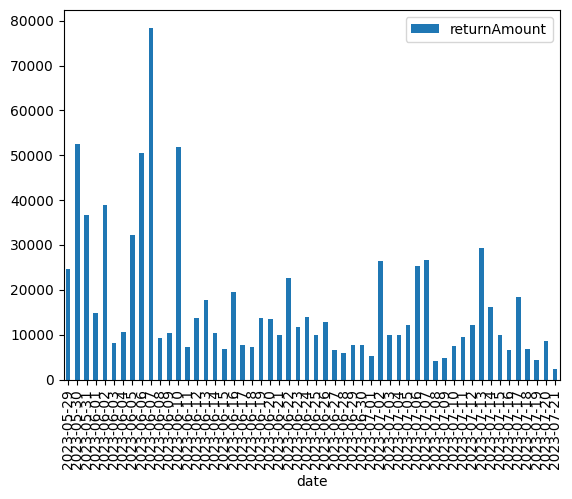

In [29]:
astro_sell[['date','returnAmount']].groupby('date').sum().plot(kind='bar')

<Axes: xlabel='date'>

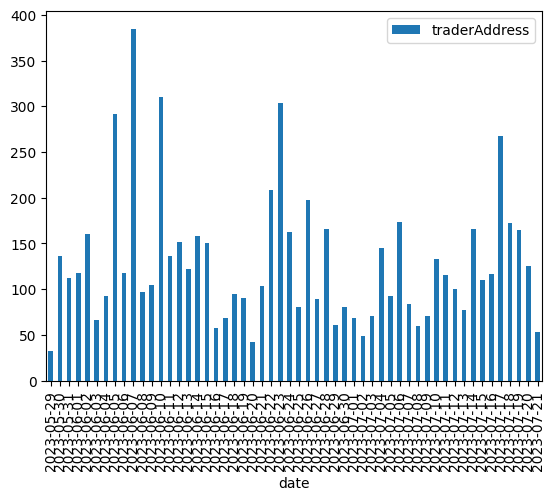

In [30]:
astro_sell[['date','traderAddress']].groupby('date').count().plot(kind='bar')